In [4]:
import numpy as np
import pandas as pd
from collections import Counter
from itertools import combinations
import os

# Sample data: list of sentences
sentences = [
    "this is a sample sentence",
    "this sentence is another example",
    "example sentence with sample words",
    "more words in this example sentence"
]

# Read content of a text file
test_file = "../tests/data/raw/easyNer_example_abstract.txt"
with open(test_file, 'r') as file:
    sentences = file.readlines()


# Normalize the text
sentences = [sentence.strip().lower() for sentence in sentences]

# Tokenize sentences into words
tokenized_sentences = [sentence.split() for sentence in sentences]

# Create a list of all unique words
all_words = sorted(set(word for sentence in tokenized_sentences for word in sentence))

# Create a dictionary to map words to indices
word_to_index = {word: i for i, word in enumerate(all_words)}

# Initialize the co-occurrence matrix
co_occurrence_matrix = np.zeros((len(all_words), len(all_words)), dtype=int)

# Populate the co-occurrence matrix
for sentence in tokenized_sentences:
    for word1, word2 in combinations(sentence, 2):
        index1, index2 = word_to_index[word1], word_to_index[word2]
        co_occurrence_matrix[index1, index2] += 1
        co_occurrence_matrix[index2, index1] += 1

# Convert the matrix to a DataFrame for better readability
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=all_words, columns=all_words)

def drop_below_threshold(df, threshold):
    """
    Drop all co-occurrence frequencies below a given threshold.

    Parameters:
    df (pd.DataFrame): The co-occurrence matrix as a DataFrame.
    threshold (int): The threshold below which frequencies will be set to 0.

    Returns:
    pd.DataFrame: The modified DataFrame with frequencies below the threshold set to 0.
    """
    df[df < threshold] = 0
    return df

def extract_top_co_occurrences(df, word, top_n=5):
    """
    Extract the top co-occurrences of a word from a co-occurrence DataFrame.

    Parameters:
    df (pd.DataFrame): The co-occurrence matrix as a DataFrame.
    word (str): The word for which to extract co-occurrences.
    top_n (int): The number of top co-occurrences to extract.

    Returns:
    pd.Series: The Series of top co-occurrences.
    """
    return df[word].sort_values(ascending=False).head(top_n)

def keep_top_x_cooccurrences(df, top_x):
    """
    Keep only the top X co-occurrences in the DataFrame.

    Parameters:
    df (pd.DataFrame): The co-occurrence matrix as a DataFrame.
    top_x (int): The number of top co-occurrences to keep.

    Returns:
    pd.DataFrame: The modified DataFrame with only the top X co-occurrences.
    """
    # Flatten the DataFrame and sort by values
    flattened = df.stack().sort_values(ascending=False)

    # Keep only the top X co-occurrences
    top_cooccurrences = flattened.head(top_x)

    # Create a new DataFrame with the same shape, filled with zeros
    new_df = pd.DataFrame(np.zeros(df.shape), index=df.index, columns=df.columns)

    # Populate the new DataFrame with the top co-occurrences
    for (word1, word2), value in top_cooccurrences.items():
        new_df.at[word1, word2] = value
        new_df.at[word2, word1] = value  # Ensure symmetry

    return new_df

def drop_self_co_occurrences(df):
    """
    Drop all co-occurrences of words with themselves.

    Parameters:
    df (pd.DataFrame): The co-occurrence matrix as a DataFrame.

    Returns:
    pd.DataFrame: The modified DataFrame with self-co-occurrences removed.
    """
    np.fill_diagonal(df.values, 0)
    return df

def drop_empty_rows_columns(df):
    """
    Drop all rows and columns that have no co-occurrences.

    Parameters:
    df (pd.DataFrame): The co-occurrence matrix as a DataFrame.

    Returns:
    pd.DataFrame: The modified DataFrame with empty rows and columns removed.
    """
    # Drop rows and columns where all values are 0
    df = df.loc[(df != 0).any(axis=1), (df != 0).any(axis=0)]
    return df

# Apply the function to the co-occurrence DataFrame
co_occurrence_df = drop_below_threshold(co_occurrence_df, threshold=30)

# Choose a word that exists in the sentences
# top_co_occurrences = extract_top_co_occurrences(co_occurrence_df, word='example', top_n=1)
# print(top_co_occurrences)

# co_occurrence_df = keep_top_x_cooccurrences(co_occurrence_df, top_x=1)
co_occurrence_df = drop_self_co_occurrences(co_occurrence_df)
co_occurrence_df = drop_empty_rows_columns(co_occurrence_df)
print(co_occurrence_df)
export_dir = "../tests/data/generated/co_occurrence_matrix.csv"
# Create dir if it does not exist
import os
os.makedirs(os.path.dirname(export_dir), exist_ok=True)
# Export to csv
co_occurrence_df.to_csv(export_dir)

           a  and  can  entities  for  in  is  medical  ner   of  on  \
a          0   52    0         0    0   0   0        0    0   44   0   
and       52    0   52        39   39  52  39       65   39  143  39   
can        0   52    0         0    0   0   0        0    0   44   0   
entities   0   39    0         0    0   0   0        0    0   33   0   
for        0   39    0         0    0   0   0        0    0   33   0   
in         0   52    0         0    0   0   0        0    0   44   0   
is         0   39    0         0    0   0   0        0    0   33   0   
medical    0   65    0         0    0   0   0        0    0   55   0   
ner        0   39    0         0    0   0   0        0    0   33   0   
of        44  143   44        33   33  44  33       55   33    0  33   
on         0   39    0         0    0   0   0        0    0   33   0   
pipeline   0   65    0         0    0   0   0        0    0   55   0   
research   0   65    0         0    0   0   0        0    0   55

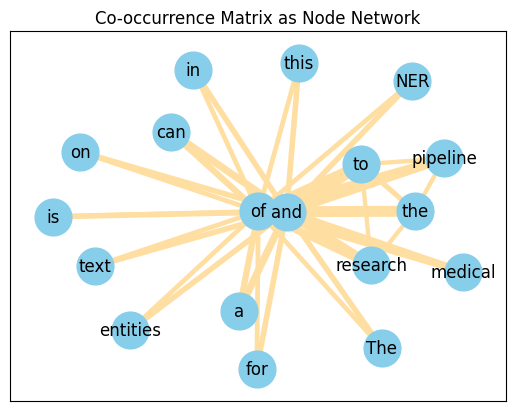

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

# Configuration dictionary for visualization parameters
config = {
    'node_color': 'skyblue',
    'node_size': 700,
    'edge_color': '#FFDEA2',
    'font_size': 12,
    'font_family': 'sans-serif',
    'layout_seed': 42
}

# Create a graph from the co-occurrence matrix
G = nx.Graph()

# Add edges with weights and collect nodes that have co-occurrences
nodes_with_edges = set()
for i, word1 in enumerate(all_words):
    for j, word2 in enumerate(all_words):
        if co_occurrence_matrix[i, j] > 0:
            G.add_edge(word1, word2, weight=co_occurrence_matrix[i, j])
            nodes_with_edges.add(word1)
            nodes_with_edges.add(word2)

# Draw the graph
pos = nx.spring_layout(G, seed=config['layout_seed'])  # positions for all nodes
edges = G.edges(data=True)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=config['node_size'], node_color=config['node_color'])

# Draw edges with varying widths based on the logarithm of the weight
shrinking_factor = 0.1
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[shrinking_factor * (d['weight'] + 1) for (u, v, d) in edges], edge_color=config['edge_color'])

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=config['font_size'], font_family=config['font_family'])

plt.title("Co-occurrence Matrix as Node Network")
plt.show()


In [ ]:
# Install and load the igraph package
if (!requireNamespace("igraph", quietly = TRUE)) {
    install.packages("igraph")
}
library(igraph)

message("igraph package loaded successfully")
# Read the co-occurrence matrix from a CSV file
co_occurrence_df <- read.csv("co_occurrence_matrix.csv", row.names = 1)

# Convert the co-occurrence matrix to an igraph object
g <- graph_from_adjacency_matrix(as.matrix(co_occurrence_df), mode = "undirected", weighted = TRUE)

# Set node and edge attributes
V(g)$label <- rownames(co_occurrence_df)
E(g)$weight <- E(g)$weight

# Plot the graph
plot(g, vertex.color = "skyblue", vertex.size = 20, edge.width = E(g)$weight, edge.color = "yellow", vertex.label.cex = 0.8, vertex.label.family = "sans")